In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/akshay/proj/ephys_analysis')

from myinit import *
from load_neural_data import *

from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cosine as cosdist
from scipy.optimize import minimize
from sklearn.metrics import log_loss

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.titleweight'] = 'bold'

sns.set(font='Helvetica', style='ticks')
matplotlib.rcParams['text.color'] = [0,0,0]
sns.set_palette(sns.husl_palette(h=0.6))
colors = sns.color_palette()

# Load neural data, DNN features, and behavioral data

In [2]:
data_sty = load_from_hdf5('data/objaverse-shapenet-stylized_ephys-data_2024.h5')

In [3]:
features = load_from_hdf5('features/features_objaverseshapenet-stylized_1000pcs.h5')

In [4]:
behav_df = pd.read_parquet('data/human-behavior-data_jan2025_processed.parquet')

In [5]:
rows = []
for sess in tqdm(data_sty):
    resp_peak = data_sty[sess]['repavg']['response_peak']
    stim_name = data_sty[sess]['repavg']['stimulus_name']
    brain_area = data_sty[sess]['neuron_metadata']['brain_area']
    ncsnr = data_sty[sess]['neuron_metadata']['ncsnr']
    n_images, n_neurons = resp_peak.shape
    for ii in range(n_images):
        for ni in range(n_neurons):
            rows.append({'monkey': sess.split('_')[0],
                         'image': stim_name[ii].decode('utf-8'), 
                         'neuron': f'{sess}_{ni}', 
                         'area': brain_area[ni].decode('utf-8').split('_')[-1], # get rid of l and r
                         'ncsnr': ncsnr[ni],
                         'response': resp_peak[ii,ni],
                        })
neural_df = pd.DataFrame(rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


# Functions

In [29]:
def softmin(x, exponent=1.0):
    """
    Compute the softmin of vector x with an optional exponent.
    
    Parameters:
    x (array-like): Input vector.
    exponent (float): The exponent to be applied to each element before softmin. Default is 1.0.
    
    Returns:
    numpy.ndarray: Softmin result.
    """
    exp_neg_x = np.exp(-exponent * np.array(x))
    return exp_neg_x / np.sum(exp_neg_x)


def zeroshot_linkingmodel2(feats, behavdf, img_fns_unique, dist = 'cosine', softmax=False):
    choices = []
    for i in range(len(behavdf)):
        if behavdf['sample'].values[i] not in img_fns_unique or behavdf['choice0'].values[i] not in img_fns_unique or behavdf['choice1'].values[i] not in img_fns_unique:
            choices.append(np.nan)
            continue
        sample_feat = np.squeeze(feats[img_fns_unique == behavdf['sample'].values[i],:])
        choice0_feat = np.squeeze(feats[img_fns_unique == behavdf['choice0'].values[i],:])
        choice1_feat = np.squeeze(feats[img_fns_unique == behavdf['choice1'].values[i],:])

        # print(choice1_feat.shape)
        if softmax:
            choices.append(softmin([cosdist(sample_feat, choice0_feat),
                                 cosdist(sample_feat, choice1_feat)], exponent=100)[1])
        else:
            choices.append(np.argmin([cosdist(sample_feat, choice0_feat),
                                     cosdist(sample_feat, choice1_feat)]))
    return choices

def zeroshot_linkingmodel(feats, behavdf, img_fns_unique, dist = 'cosine', softmax=False):
    if dist == 'cosine':
        dist_mtx = squareform(pdist(feats, metric='cosine'))
    else: # correlation matrix
        dist_mtx = 1 - np.corrcoef(feats)
        
    choices = []
    for i in range(len(behavdf)):
        if behavdf['sample'].values[i] not in img_fns_unique or behavdf['choice0'].values[i] not in img_fns_unique or behavdf['choice1'].values[i] not in img_fns_unique:
            choices.append(np.nan)
            continue
        sample_idx = np.where(img_fns_unique == behavdf['sample'].values[i])[0][0]
        choice0_idx = np.where(img_fns_unique == behavdf['choice0'].values[i])[0][0]
        choice1_idx = np.where(img_fns_unique == behavdf['choice1'].values[i])[0][0]

        # print(choice1_feat.shape)
        if softmax:
            choices.append(softmin([dist_mtx[sample_idx, choice0_idx],
                                    dist_mtx[sample_idx, choice1_idx]], exponent=100)[1])
        else:
            choices.append(np.argmin([dist_mtx[sample_idx, choice0_idx],
                                      dist_mtx[sample_idx, choice1_idx]]))
    return choices

def biasedsample_linkingmodel(feats, behavdf, img_fns_unique, dist = cosdist, train_size=0.8,
                              n_iters=1000, sample_size=25):
    nRows = len(behavdf)
    shuff_idx = np.random.permutation(nRows)
    train_idx, test_idx = shuff_idx[:int(nRows*train_size)], shuff_idx[int(nRows*train_size):]

    train_df, test_df = behavdf.loc[train_idx].reset_index(), behavdf.loc[test_idx].reset_index()

    results = {'sample': [], 'shapeacc_train': [], 'shapeacc_test': []}
    for i in range(n_iters):
        sample = np.random.choice(feats.shape[1], (sample_size,))
        
        train_choices = zeroshot_linkingmodel(feats[:,sample], train_df, img_fns_unique)
        test_choices = zeroshot_linkingmodel(feats[:,sample], test_df, img_fns_unique)

        results['sample'].append(sample)
        results['shapeacc_train'].append(np.nanmean(train_choices))
        results['shapeacc_test'].append(np.nanmean(test_choices))
    return results

def decode_utf(np_str_array):
    return np.array([x.decode('utf-8') for x in np_str_array])

# Run linking model

In [30]:
# run zero-shot linking model on behavioral data
thresh=0.1
sess = data_sty['baby1_240117-240419']
model_choices = {}
model_behav = behav_df[['trial_id', 'stim_set', 'sample', 'sample_categ', 'sample_duration', 
                        'sample_object', 'sample_texture', 'choice0', 'choice1', 'tasktype', 
                        'response']].copy().rename(columns={'response': 'behavior'}).loc[behav_df['tasktype'].isin(['texcolvscateg', 'colorvscateg', 
                                                                                                                    'texcolvsexemplar', 'colorvsexemplar'])]

modelnames = []
sessnames = []

modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]
img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(sess['repavg']['stimulus_name'])])
for modelname in tqdm(modellayers):
    model_choices[modelname] = zeroshot_linkingmodel(features[modelname], behav_df, img_fns_unique, softmax = False)
    model_behav[modelname] = model_choices[modelname]
    modelnames.append(modelname)

for si, sess_name in tqdm(enumerate(data_sty), total=len(data_sty)):
    resp_peak = data_sty[sess_name]['repavg']['response_peak']
    img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(data_sty[sess_name]['repavg']['stimulus_name'])])
    
    brain_areas = data_sty[sess_name]['neuron_metadata']['brain_area']
    sc = data_sty[sess_name]['neuron_metadata']['reliability']
    if type(brain_areas[0])==bytes:
        brain_areas = np.array([x.decode('utf-8') for x in brain_areas])
    uareas = np.unique(brain_areas)
    for ai, area in enumerate(uareas):
        avgr = resp_peak[:, (brain_areas==area)*(sc>thresh)]
        if avgr.shape[1]<=1: continue
        model_choices[sess_name+'_'+area] = zeroshot_linkingmodel(avgr, behav_df, img_fns_unique, softmax=False)
        model_behav[sess_name+'_'+area] = model_choices[sess_name + '_' + area]
        sessnames.append(sess_name + '_' + area)
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:35<00:00, 10.56s/it]


(10, 7001)

In [ ]:
n_iters = 100
n_smp_size = 100
thresh=0.1

sess = data_sty['baby1_240117-240419']
model_choices = {}
modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]
img_fns_unique = np.array([os.path.splitext(os.path.basename(x))[0] for x in decode_utf(sess['repavg']['stimulus_name'])])
for modelname in tqdm(modellayers):
    n_feats = features[modelname].shape[1]
    model_choices[modelname] = [
        zeroshot_linkingmodel(features[modelname][:, np.random.randint(0, n_feats, n_smp_size)], behav_df, img_fns_unique,
                              softmax = False) for _ in range(n_iters)
    ]

uareas = neural_df['area'].unique()
for ai, area in tqdm(enumerate(uareas), total=len(uareas)):
    # Group by neuron and image, averaging the response
    resp = neural_df[(neural_df['area'] == area) & (neural_df['ncsnr'] > 0.01)]
    grouped = resp.groupby(['neuron', 'image'], as_index=False)['response'].mean()
    
    # Pivot so that rows = neurons, columns = images, values = mean response
    resp_pivot = grouped.pivot(index='neuron', columns='image', values='response')
    imgs_unique = resp_pivot.columns
    model_choices[area] = [
        zeroshot_linkingmodel(np.array(resp_pivot.loc[np.random.choice(resp_pivot.index, size=n_smp_size, replace=True)]).T,
                              behav_df, imgs_unique, softmax = False) for _ in range(n_iters)
    ]

 30%|███████████████████████████████████████████████████▎                                                                                                                       | 3/10 [46:25<1:48:20, 928.66s/it]

In [187]:
np.array(model_choices['alexnet_classifier.2']).shape

(100, 27298)

In [182]:
uareas = neural_df['area'].unique()
for ai, area in tqdm(enumerate(uareas), total=len(uareas)):
    if area in model_choices: 
        continue
    else:
        print(area)

    # Group by neuron and image, averaging the response
    resp = neural_df[(neural_df['area'] == area) & (neural_df['ncsnr'] > 0.01)]
    grouped = resp.groupby(['neuron', 'image'], as_index=False)['response'].mean()
    
    # Pivot so that rows = neurons, columns = images, values = mean response
    resp_pivot = grouped.pivot(index='neuron', columns='image', values='response')
    imgs_unique = resp_pivot.columns
    model_choices[area] = [
        zeroshot_linkingmodel(np.array(resp_pivot.loc[np.random.choice(resp_pivot.index, size=n_smp_size, replace=True)]).T,
                              behav_df, imgs_unique, softmax = False) for _ in range(n_iters)
    ]

  0%|                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

pIT

 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 2/5 [00:09<00:14,  4.67s/it]


KeyboardInterrupt: 

In [206]:
gb = bd[bd.sample_duration==500].groupby('tasktype')['alexnet_classifier.2'].mean()


tasktype
colorvscateg         [0.4559500328731098, 0.5302432610124918, 0.587...
colorvsexemplar      [0.47954329210275926, 0.5883285759594037, 0.63...
texcolcategvsnone    [0.7838456507521255, 0.6690647482014388, 0.657...
texcolvscateg        [0.29714937286202964, 0.44469783352337516, 0.4...
texcolvsexemplar     [0.3655701754385965, 0.5252192982456141, 0.532...
Name: alexnet_classifier.2, dtype: object

In [219]:
model_behav = behav_df[['trial_id', 'stim_set', 'sample', 'sample_categ', 'sample_duration', 
                        'sample_object', 'sample_texture', 'choice0', 'choice1', 'tasktype', 
                        'response']].copy().rename(columns={'response': 'behavior'})#.loc[behav_df['tasktype'].isin(['texcolvscateg', 'colorvscateg', 
# bd = behav_df.copy()
for model in modelnames:
    model_behav[model] = list(np.array(model_choices[model]).T)
gb = model_behav[model_behav.sample_duration==500].groupby('tasktype')

b_gb = gb['behavior']
m_gb = gb[modelnames]

In [218]:
gb.agg(np.nanmean)

tasktype
colorvscateg         [0.4559500328731098, 0.5302432610124918, 0.587...
colorvsexemplar      [0.47954329210275926, 0.5883285759594037, 0.63...
texcolcategvsnone    [0.7838456507521255, 0.6690647482014388, 0.657...
texcolvscateg        [0.29714937286202964, 0.44469783352337516, 0.4...
texcolvsexemplar     [0.3655701754385965, 0.5252192982456141, 0.532...
Name: alexnet_classifier.2, dtype: object

In [ ]:
tasktypess = [['texcolvscateg', 'colorvscateg'],['texcolvsexemplar', 'colorvsexemplar']]

model_behav = behav_df[['trial_id', 'stim_set', 'sample', 'sample_categ', 'sample_duration', 
                        'sample_object', 'sample_texture', 'choice0', 'choice1', 'tasktype', 
                        'response']].copy().rename(columns={'response': 'behavior'})#.loc[behav_df['tasktype'].isin(['texcolvscateg', 'colorvscateg', 
# bd = behav_df.copy()
for model in modelnames:
    model_behav[model] = list(np.array(model_choices[model]).T)
gb = model_behav[model_behav.sample_duration==500].groupby('tasktype')

b_gb = gb['behavior']
m_gb = gb[modelnames]

colors = sns.color_palette()
colors = [colors[1], colors[2]]

for tasktypes in tasktypess:
    fig, ax = plt.subplots(figsize=(6,4))
    
    for ti, tasktype in enumerate(tasktypes):
        
        Y = gb.agg(np.nanmean).loc[tasktype, modelnames]
        Yerr = 2*gb.agg(SE).loc[tasktype, modelnames]
    
        ax.fill_between([0-.5, len(modelnames)-.5], 
                        b_gb.agg(np.nanmean).loc[tasktype, 'behavior'] - b_gb.agg(SE).loc[tasktype, 'behavior'],
                        b_gb.agg(np.nanmean).loc[tasktype, 'behavior'] + b_gb.agg(SE).loc[tasktype, 'behavior'],
                        color=colors[ti], alpha=0.4,
                       )
        b0 = sns.color_palette('tab10')[0]
        ax.errorbar(np.arange(len(Y)), Y.loc[modellayers], yerr=Yerr.loc[modellayers], color=colors[ti], marker='o', ls='none',
                   label = tasktype)
        # for i in np.arange(0, 30, 3):
        #     ax.errorbar(np.arange(i, i+3), Y.loc[modellayers[i:i+3]],
        #                 yerr = Yerr.loc[modellayers[i:i+3]], ls = '-', marker='o', color=colors[ti], label = tasktype if i==0 else None,
        #                )
    ax.set_xticks(np.arange(len(Y)))
    ax.set_xticklabels(modellayers, rotation=90);
    ax.plot([-.5, len(modelnames)-.5], [0.5, 0.5], ls=':', color='gray')
    ax.set_ylim(0, 1.0)
    level = tasktypes[0].split('vs')[1]
    ax.set_title(f'DNN models: {level}-level shape bias')
    ax.set_ylabel(f'{level}-level Shape accuracy \n (proportion choices for shape)')
    ax.legend(frameon=False)
    sns.despine(trim=True)
    # fig.savefig(f'{figdir}/dnns/DNN-behavior_cueconflict_zeroshot-accuracy_{level}.pdf', bbox_inches='tight', transparent=True)

# Plot results

In [22]:
figdir = 'figures/objaverseshapenet-stylized_2024'

/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

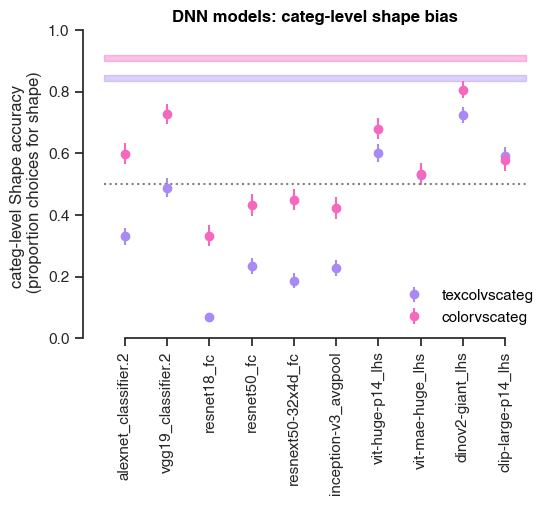

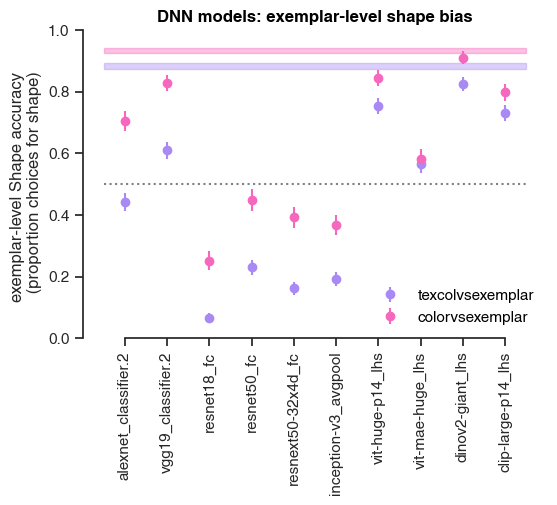

In [32]:
tasktypess = [['texcolvscateg', 'colorvscateg'],['texcolvsexemplar', 'colorvsexemplar']]

for tasktypes in tasktypess:
    colors = sns.color_palette()
    colors = [colors[1], colors[2]]
    fig, ax = plt.subplots(figsize=(6,4))
    gb = model_behav[model_behav.sample_duration==500].groupby('tasktype')[['behavior'] + modelnames + sessnames]
    
    for ti, tasktype in enumerate(tasktypes):
        
        Y = gb.agg(np.nanmean).loc[tasktype, modelnames]
        Yerr = 2*gb.agg(SE).loc[tasktype, modelnames]
    
        ax.fill_between([0-.5, len(modelnames)-.5], 
                        gb.agg(np.nanmean).loc[tasktype, 'behavior'] - gb.agg(SE).loc[tasktype, 'behavior'],
                        gb.agg(np.nanmean).loc[tasktype, 'behavior'] + gb.agg(SE).loc[tasktype, 'behavior'],
                        color=colors[ti], alpha=0.4,
                       )
        b0 = sns.color_palette('tab10')[0]
        ax.errorbar(np.arange(len(Y)), Y.loc[modellayers], yerr=Yerr.loc[modellayers], color=colors[ti], marker='o', ls='none',
                   label = tasktype)
        # for i in np.arange(0, 30, 3):
        #     ax.errorbar(np.arange(i, i+3), Y.loc[modellayers[i:i+3]],
        #                 yerr = Yerr.loc[modellayers[i:i+3]], ls = '-', marker='o', color=colors[ti], label = tasktype if i==0 else None,
        #                )
    ax.set_xticks(np.arange(len(Y)))
    ax.set_xticklabels(modellayers, rotation=90);
    ax.plot([-.5, len(modelnames)-.5], [0.5, 0.5], ls=':', color='gray')
    ax.set_ylim(0, 1.0)
    level = tasktypes[0].split('vs')[1]
    ax.set_title(f'DNN models: {level}-level shape bias')
    ax.set_ylabel(f'{level}-level Shape accuracy \n (proportion choices for shape)')
    ax.legend(frameon=False)
    sns.despine(trim=True)
    # fig.savefig(f'{figdir}/dnns/DNN-behavior_cueconflict_zeroshot-accuracy_{level}.pdf', bbox_inches='tight', transparent=True)

,index,subject_id,response,RT,sample,choice0,choice1,sample_duration,tasktype,stim_set,...,choice0_color,choice0_animacy,choice1_fullpath,choice1_categ,choice1_object,choice1_objview,choice1_texture,choice1_pattern,choice1_color,choice1_animacy
0,0,56e4b2e044b184000b894159,1,1194,suit_84181c6828384934b1df0f2120d9f77c_view-002...,alarmclock_b1e85b72b4d14309899f037ff46879e2_vi...,suit_84181c6828384934b1df0f2120d9f77c_view-015...,500,texcolvsexemplar,objaverse,...,b'orig',b'inanimate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'person',b'suit_84181c6828384934b1df0f2120d9f77c',b'suit_84181c6828384934b1df0f2120d9f77c_view-015',b'tigerstripes_blue',b'tigerstripes',b'blue',b'animate'
1,1,56e4b2e044b184000b894159,1,1265,person_75fdc43a92d9469f8dc9176b56d75ba6_view-0...,bicycle_6ff55560e82c47b98804d0ca3843f7ba_view-...,tank_8d301875ea134faaa5a8c9cd2459f956_view-001...,500,texcolvscateg,objaverse,...,b'orig',b'inanimate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'person',b'tank_8d301875ea134faaa5a8c9cd2459f956',b'tank_8d301875ea134faaa5a8c9cd2459f956_view-001',b'shiny_red',b'shiny',b'red',b'animate'
2,2,56e4b2e044b184000b894159,0,3172,ship-12_view-00-stylized-leaves2,tvmonitor-02_view-05-stylized-leaves2,ship-22_view-00-stylized-bricks1,500,texcolvscateg,shapenet,...,b'orig',b'inanimate',b'/home/akshay/stimuli/shapenet_textured/ship-...,b'ship',b'ship-22',b'ship-22_view-00',b'bricks1',b'bricks1',b'orig',b'inanimate'
3,3,56e4b2e044b184000b894159,1,790,suit_2c78dd65f2d0483f8ab9a97151d840f5_view-004...,fryingpan_1fdc84a7be2c4348b281490c89d76062_vie...,suit_2c78dd65f2d0483f8ab9a97151d840f5_view-007...,500,texcolvsexemplar,objaverse,...,b'blue',b'inanimate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'person',b'suit_2c78dd65f2d0483f8ab9a97151d840f5',b'suit_2c78dd65f2d0483f8ab9a97151d840f5_view-007',b'tigerstripes_red',b'tigerstripes',b'red',b'animate'
4,4,56e4b2e044b184000b894159,1,815,bicycle_3bde1ab67c6448169b604dedad6828d8_view-...,trenchcoat_99565b63b54d429f99526428639037bf_vi...,bicycle_5ebd3720da554fa2a60e0fa280c5ae7a_view-...,500,colorvscateg,objaverse,...,b'red',b'animate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'bicycle',b'bicycle_5ebd3720da554fa2a60e0fa280c5ae7a',b'bicycle_5ebd3720da554fa2a60e0fa280c5ae7a_vie...,b'eyes_blue',b'eyes',b'blue',b'inanimate'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30278,295,67914eb5f22224c1335626b4,0,1545,sofa_0eb6c94aa40c41b480cf35de229e8e88_view-001...,car_8d333a52ca6b4afbaba8002d236c5ef0_view-000-...,sofa_5ec9697d85654005b27fd29bd6df987e_view-001...,50,colorvscateg,objaverse,...,b'blue',b'inanimate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'sofa',b'sofa_5ec9697d85654005b27fd29bd6df987e',b'sofa_5ec9697d85654005b27fd29bd6df987e_view-001',b'shiny_red',b'shiny',b'red',b'inanimate'
30279,296,67914eb5f22224c1335626b4,0,802,car_2cec81ac7d484c8890ab28cc04e4a3b3_view-012-...,elephant_2e3a1a3358374a5bb55f7e9a65d5eefb_view...,car_2cec81ac7d484c8890ab28cc04e4a3b3_view-004-...,100,texcolvsexemplar,objaverse,...,b'blue',b'animate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'car',b'car_2cec81ac7d484c8890ab28cc04e4a3b3',b'car_2cec81ac7d484c8890ab28cc04e4a3b3_view-004',b'tigerstripes_red',b'tigerstripes',b'red',b'inanimate'
30280,297,67914eb5f22224c1335626b4,0,3561,glove_3f94f913d04341cdb1e1c8dd6ed94fab_view-00...,teddybear_8ce1da97aa404bc099a898f29a3025ae_vie...,glove_3f94f913d04341cdb1e1c8dd6ed94fab_view-01...,50,texcolvsexemplar,objaverse,...,b'blue',b'animate',b'/home/akshay/stimuli/objaverse_stylized_smal...,b'glove',b'glove_3f94f913d04341cdb1e1c8dd6ed94fab',b'glove_3f94f913d04341cdb1e1c8dd6ed94fab_view-...,b'rocks_red',b'rocks',b'red',b'animate'
30281,298,67914eb5f22224c1335626b4,1,603,ship-03_view-00-stylized-elephant1,desk-98_view-04-stylized-elephant1,ship-03_view-05-stylized-bricks1,50,texcolvsexemplar,shapenet,...,b'orig',b'inanimate',b'/home/akshay/stimuli/shapenet_textured/ship-...,b'ship',b'ship-03',b'sh

/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

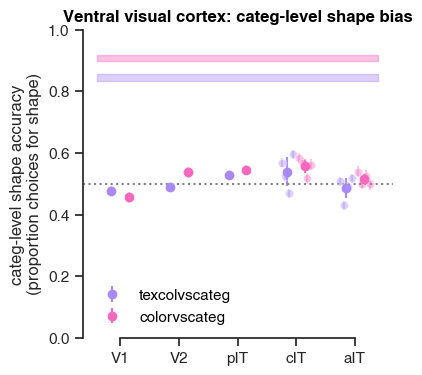

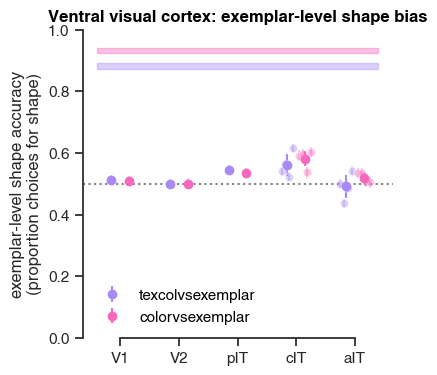

In [26]:
tasktypess = [['texcolvscateg', 'colorvscateg'],['texcolvsexemplar', 'colorvsexemplar']]

gb = model_behav[model_behav.sample_duration==500].groupby('tasktype')[['behavior'] + modelnames + sessnames]
for tasktypes in tasktypess:
    
    
    fig, ax = plt.subplots(figsize=(4,4))
    sess_names = {'V1': ['paul_240405-240416_V1'],
                  'V2': ['paul_240405-240416_V2'],
                  'pIT': ['paul_240405-240416_pIT'],
                  'cIT': ['baby1_240117-240419_cIT', 'sweetie_20240117-20240419_l_cIT', 
                          'louie_20240117-20240419_l_cIT', 'paul_20240405-20240416_l_cIT', ],
                  'aIT': ['baby1_240117-240419_aIT', 'red_20240117-20240419_l_aIT', 
                          'baby1_20240117-20240419_r_aIT', 'anthony_20240117-20240419_r_aIT',],
                          # 'jordan_20240117-20240121_l_aIT']
                 }

    xoff = np.linspace(-.15, .15, len(tasktypes))
    for ti, tasktype in enumerate(tasktypes):
        
        Y = gb.agg(np.nanmean).loc[tasktype, sessnames]
        Yerr = gb.agg(SE).loc[tasktype, sessnames]
        
        ax.fill_between([0-.4, len(sess_names)-1+.4], 
                        gb.agg(np.nanmean).loc[tasktype, 'behavior'] - gb.agg(SE).loc[tasktype, 'behavior'],
                        gb.agg(np.nanmean).loc[tasktype, 'behavior'] + gb.agg(SE).loc[tasktype, 'behavior'],
                        color=colors[ti], alpha=0.4,
                       )
        
        for si, area in enumerate(sess_names):
            Ys = Y.loc[sess_names[area]]
            xshifts = np.linspace(-.1, .1, len(sess_names[area])) if len(sess_names[area])>1 else 0
            ax.errorbar(si+xshifts+xoff[ti], Ys, yerr=Yerr.loc[sess_names[area]], 
                        ls='none', color=colors[ti], marker='o', alpha=0.4, markeredgecolor='white')
        ax.errorbar(np.arange(len(sess_names))+xoff[ti], [np.nanmean(Y.loc[sess_names[area]]) for area in sess_names], 
               yerr=[SE(Y.loc[sess_names[area]]) for area in sess_names], color=colors[ti], marker='o', ls='none', label = tasktype)
    ax.set_xticks(np.arange(len(sess_names)), sess_names.keys())
    ax.legend(frameon=False)
    level = tasktypes[0].split('vs')[1]
    ax.set_title(f'Ventral visual cortex: {level}-level shape bias')
    ax.set_ylabel(f'{level}-level shape accuracy\n(proportion choices for shape)')
    ax.axhline(0.5, ls=':', color='gray')
    ax.set_ylim(0, 1.0)
    
    sns.despine(trim=True)
    fig.savefig(f'{figdir}/allmonkeys/monkey-behavior_cueconflict_zeroshot-accuracy_{level}.pdf', bbox_inches='tight', transparent=True)

In [184]:
np.array(model_choices['cIT']).shape

(100, 27298)

In [185]:
model_behav

(22673, 11)

In [ ]:
tasktypess = [['texcolvscateg', 'colorvscateg'],['texcolvsexemplar', 'colorvsexemplar']]

gb = model_behav[model_behav.sample_duration==500].groupby('tasktype')[['behavior'] + modelnames + sessnames]
for tasktypes in tasktypess:
    
    
    fig, ax = plt.subplots(figsize=(4,4))
    areas = ['cIT', 'aIT']

    xoff = np.linspace(-.15, .15, len(tasktypes))
    for ti, tasktype in enumerate(tasktypes):
        
        Y = gb.agg(np.nanmean).loc[tasktype, sessnames]
        Yerr = gb.agg(SE).loc[tasktype, sessnames]
        
        ax.fill_between([0-.4, len(sess_names)-1+.4], 
                        gb.agg(np.nanmean).loc[tasktype, 'behavior'] - gb.agg(SE).loc[tasktype, 'behavior'],
                        gb.agg(np.nanmean).loc[tasktype, 'behavior'] + gb.agg(SE).loc[tasktype, 'behavior'],
                        color=colors[ti], alpha=0.4,
                       )
        
        for si, area in enumerate(sess_names):
            Ys = Y.loc[sess_names[area]]
            xshifts = np.linspace(-.1, .1, len(sess_names[area])) if len(sess_names[area])>1 else 0
            ax.errorbar(si+xshifts+xoff[ti], Ys, yerr=Yerr.loc[sess_names[area]], 
                        ls='none', color=colors[ti], marker='o', alpha=0.4, markeredgecolor='white')
        ax.errorbar(np.arange(len(sess_names))+xoff[ti], [np.nanmean(Y.loc[sess_names[area]]) for area in sess_names], 
               yerr=[SE(Y.loc[sess_names[area]]) for area in sess_names], color=colors[ti], marker='o', ls='none', label = tasktype)
    ax.set_xticks(np.arange(len(sess_names)), sess_names.keys())
    ax.legend(frameon=False)
    level = tasktypes[0].split('vs')[1]
    ax.set_title(f'Ventral visual cortex: {level}-level shape bias')
    ax.set_ylabel(f'{level}-level shape accuracy\n(proportion choices for shape)')
    ax.axhline(0.5, ls=':', color='gray')
    ax.set_ylim(0, 1.0)
    
    sns.despine(trim=True)
    fig.savefig(f'{figdir}/allmonkeys/monkey-behavior_cueconflict_zeroshot-accuracy_{level}.pdf', bbox_inches='tight', transparent=True)

# Stats

In [7]:
model_behav

,trial_id,stim_set,sample,sample_categ,sample_duration,sample_object,sample_texture,choice0,choice1,tasktype,...,baby1_240117-240419_aIT,baby1_240117-240419_cIT,jordan_20240117-20240121_l_aIT,louie_20240117-20240419_l_cIT,paul_20240405-20240416_l_cIT,paul_240405-240416_V1,paul_240405-240416_V2,paul_240405-240416_pIT,red_20240117-20240419_l_aIT,sweetie_20240117-20240419_l_cIT
0,4913,objaverse,suit_84181c6828384934b1df0f2120d9f77c_view-002...,b'person',500,b'suit_84181c6828384934b1df0f2120d9f77c',b'eyes',alarmclock_b1e85b72b4d14309899f037ff46879e2_vi...,suit_84181c6828384934b1df0f2120d9f77c_view-015...,texcolvsexemplar,...,1,1,NaN,1,1.0,1.0,1.0,1.0,1,0
1,3232,objaverse,person_75fdc43a92d9469f8dc9176b56d75ba6_view-0...,b'person',500,b'person_75fdc43a92d9469f8dc9176b56d75ba6',b'leopard',bicycle_6ff55560e82c47b98804d0ca3843f7ba_view-...,tank_8d301875ea134faaa5a8c9cd2459f956_view-001...,texcolvscateg,...,1,1,NaN,1,1.0,1.0,0.0,1.0,0,1
2,255,shapenet,ship-12_view-00-stylized-leaves2,b'ship',500,b'ship-12',b'leaves2',tvmonitor-02_view-05-stylized-leaves2,ship-22_view-00-stylized-bricks1,texcolvscateg,...,0,1,1.0,1,NaN,NaN,NaN,NaN,0,0
3,3183,objaverse,suit_2c78dd65f2d0483f8ab9a97151d840f5_view-004...,b'person',500,b'suit_2c78dd65f2d0483f8ab9a97151d840f5',b'leopard_blue',fryingpan_1fdc84a7be2c4348b281490c89d76062_vie...,suit_2c78dd65f2d0483f8ab9a97151d840f5_view-007...,texcolvsexemplar,...,0,1,NaN,1,0.0,1.0,0.0,1.0,1,0
4,3530,objaverse,bicycle_3bde1ab67c6448169b604dedad6828d8_view-...,b'bicycle',500,b'bicycle_3bde1ab67c6448169b604dedad6828d8',b'leopard_red',trenchcoat_99565b63b54d429f99526428639037bf_vi...,bicycle_5ebd3720da554fa2a60e0fa280c5ae7a_view-...,colorvscateg,...,0,0,NaN,1,0.0,1.0,1.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30278,3588,objaverse,sofa_0eb6c94aa40c41b480cf35de229e8e88_view-001...,b'sofa',50,b'sofa_0eb6c94aa40c41b480cf35de229e8e88',b'tigerstripes_blue',car_8d333a52ca6b4afbaba8002d236c5ef0_view-000-...,sofa_5ec9697d85654005b27fd29bd6df987e_view-001...,colorvscateg,...,0,0,NaN,0,0.0,1.0,0.0,0.0,0,1
30279,3259,objaverse,car_2cec81ac7d484c8890ab28cc04e4a3b3_view-012-...,b'car',100,b'car_2cec81ac7d484c8890ab28cc04e4a3b3',b'shiny_blue',elephant_2e3a1a3358374a5bb55f7e9a65d5eefb_view...,car_2cec81ac7d484c8890ab28cc04e4a3b3_view-004-...,texcolvsexemplar,...,1,0,NaN,0,0.0,0.0,0.0,0.0,1,1
30280,5847,objaverse,glove_3f94f913d04341cdb1e1c8dd6ed94fab_view-00...,b'glove',50,b'glove_3f94f913d04341cdb1e1c8dd6ed94fab',b'shiny_blue',teddybear_8ce1da97aa404bc099a898f29a3025ae_vie...,glove_3f94f913d04341cdb1e1c8dd6ed94fab_view-01...,texcolvsexemplar,...,0,0,NaN,1,1.0,0.0,0.0,0.0,0,0
30281,596,shapenet,ship-03_view-00-stylized-elephant1,b'ship',50,b'ship-03',b'elephant1',desk-98_view-04-stylized-elephant1,ship-03_view-05-stylized-bricks1,texcolvsexemplar,...,0,0,1.0,1,NaN,NaN,NaN,NaN,1,1
